# Питон и машинное обучение

# Модуль 10. Часть 2. Сохранение и развертывание моделей


В рамках данного занятия мы посмотрим, как сохранить модель и создать приложение, в котором бы она работала.

Мы обучим модель на датасете "Пингвины" и сделаем прототип приложения, которое определяло бы вид пингвина в зависимости от запрашиваемых параметров.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

%matplotlib inline

## Шаг 1. Фиксация препроцессинга данных

1. Загрузим датасет "Пингвины" и выполним препроцессинг, фиксируя все шаги и параметры:

In [ ]:
penguins = sns.load_dataset("penguins")
penguins

In [ ]:
# удалим все NaN
penguins.drop( penguins.loc[penguins.bill_depth_mm.isnull()].index, axis=0, inplace=True)

# поставим случайный пол где он отсутствует
penguins['sex'] = penguins.sex.apply(lambda x: np.random.choice(['Male','Female']) if x is np.nan else x )

# убедимся, что пропусков нет
penguins.isnull().sum()

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

le, oe = LabelEncoder(), OrdinalEncoder()

le.fit( penguins['species'] )
print(le.classes_)

oe.fit(penguins[ ['island', 'sex'] ])
print(oe.categories_)

In [ ]:
# сохраним названия категорий в словаре:
dict_categories = {
    'species': list(le.classes_),
    'island': list(oe.categories_[0]), 
    'sex': list(oe.categories_[1]),
}
dict_categories

Напишем функцию, которая будет выполнять весь препроцессинг и проверим ее работу:

In [ ]:
penguins_categories = {'species': ['Adelie', 'Chinstrap', 'Gentoo'],
         'island': ['Biscoe', 'Dream', 'Torgersen'],
         'sex': ['Female', 'Male']
    }

def penguins_preprocessing(X: list) -> pd.DataFrame:
    """
    This function should accept list of distionaries of data we'd like to prepare for our model.
    Each dictionary key is feature name, value is text/number.
    Function returns the DataFrame with processed data.
    """

    df = pd.DataFrame(X)
    for feature, categories in penguins_categories.items():
        if feature in df.columns:
            df[feature] = df[feature].apply(lambda x: categories.index(x))
            df[feature] = df[feature].astype(np.int64)

    return df

# dry-run on 3 random choices
np.random.seed(20240401)
choice = np.random.choice(penguins.shape[0], 3, replace=False)
print("Choice: ", choice)
df = penguins.iloc[np.random.choice(penguins.shape[0], 3, )]
list_of_dicts = df.to_dict('records')
penguins_preprocessing(list_of_dicts)

Посмотрим на данные, которые должна принимать наша функция. По сути, в таком же виде должны формироваться запросы к ней.

In [ ]:
list_of_dicts

## Шаг 2. Обучение модели и ее сохранение

Обучим модель "Деревья решений" и сохраним ее. 

Если в процессе обучения потребуется вносить изменения в препроцессинг - фиксируем все в функции ```penguins_preprocessing()``` и потом возвращаемся к этому шагу.

In [ ]:
peng_proc = penguins_preprocessing( penguins.to_dict('records') )
peng_proc

In [ ]:
from sklearn.model_selection import train_test_split

X, y = peng_proc.loc[:, peng_proc.columns!='species'], \
        peng_proc.loc[:, peng_proc.columns=='species'].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2, 
                                                   random_state=20231110,
                                                   stratify = y)
print(X_train.shape)
print(X_test.shape)
print(y_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

tree = DecisionTreeClassifier(min_samples_leaf=10)

tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
y_pred_proba = tree.predict_proba(X_test)

print(y_test)
print(y_pred)

print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"F1 score: {f1_score(y_test, y_pred, average='micro')}")
print(f"ROC-AUC score: {roc_auc_score(y_test, y_pred_proba, multi_class='ovr')}")

Для сохранения модели используем библиотеку ```pickle```, она входит в состав python.

In [ ]:
import pickle

pkl_filename = "penguins_tree.pkl"
with open(pkl_filename, 'wb') as f:
    pickle.dump(tree, f)

Загружаем модель и проверяем ее на тестовой выборке:

In [ ]:
with open(pkl_filename, 'rb') as f:
    pickled_tree = pickle.load(f)
    
y_pred = pickled_tree.predict(X_test)
y_pred_proba = pickled_tree.predict_proba(X_test)

print(y_test)
print(y_pred)

print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"F1 score: {f1_score(y_test, y_pred, average='micro')}")
print(f"ROC-AUC score: {roc_auc_score(y_test, y_pred_proba, multi_class='ovr')}")

Добавим расшифровку предсказанного класса

In [ ]:
list(map(lambda x: penguins_categories['species'][x], y_pred[:10]))


## Шаг 3. Сборка приложения

Итак, наше приложение должно:
1. принимать данные
2. выполнять их препроцессинг
3. запускать модель
4. возвращать результат в человекочитаемом виде

Сначала опробуем всю сборку в тетради, а затем перенесем все это в отдельный файл.

Составим клетку, в которой:
- выполняется импорт всех модулей
- делается препроцессинг данных
- делается запуск модели и мы видим результат ее работы

Сразу поместим весь функционал модели в функцию.

Клетка должна запускаться без проблем после перезапуска ядра и без запуска всех вышележащих клеток.

In [ ]:
import numpy as np
import pandas as pd

import pickle

penguins_categories = {'species': ['Adelie', 'Chinstrap', 'Gentoo'],
         'island': ['Biscoe', 'Dream', 'Torgersen'],
         'sex': ['Female', 'Male']
    }

penguins_model = "penguins_tree.pkl"

def penguins_preprocessing(X: list) -> pd.DataFrame:
    """
    This function should accept list of distionaries of data we'd like to prepare for our model.
    Each dictionary key is feature name, value is text/number.
    Function returns the DataFrame with processed data.
    """

    df = pd.DataFrame(X)
    for feature, categories in penguins_categories.items():
        if feature in df.columns:
            df[feature] = df[feature].apply(lambda x: categories.index(x))
            df[feature] = df[feature].astype(np.int64)

    return df

def penguin_classifier(data: list) -> list:
    """
    Classifier function should accept list of crieterias and return model predictions
    """
    X = penguins_preprocessing(data)

    with open(penguins_model, 'rb') as f:
        pickled_tree = pickle.load(f)

    y_pred = pickled_tree.predict(X)
    
    return list(map(lambda x: penguins_categories['species'][x], y_pred))
    
    
    
# код ниже переносить в penguins.py не надо!    

test_penguins = [
 {
  'island': 'Dream', #'species': 'Chinstrap',
  'bill_length_mm': 52.0,
  'bill_depth_mm': 20.7,
  'flipper_length_mm': 210.0,
  'body_mass_g': 4800.0,
  'sex': 'Male'},
 {
  'island': 'Biscoe', # 'species': 'Gentoo',
  'bill_length_mm': 45.1,
  'bill_depth_mm': 14.5,
  'flipper_length_mm': 215.0,
  'body_mass_g': 5000.0,
  'sex': 'Female'}
]


penguin_classifier(test_penguins)



После того, как вышенаписанная клетка отлажена и вы видите предсказания, код из нее можно переносить в файл приложения ```penguins.py```. Точнее говоря, переносу подлежит все, кроме тестовых данных и вызова функции классификатора.

## Шаг 4. Запуск приложения

Для запуска приложение потребуется установить фреймворк ```Flask```. Это простой инструмент для создания веб-приложений на яыке Python.

In [ ]:
!pip install flask

Разрабатывать приложения на Flask - очень просто. Листинг простейшего приложения типа "Hello World" приведен ниже, он же находится в файле ```app_hello.py```:
```python
from flask import Flask

app = Flask(__name__)

@app.route("/")
def hello():
    return "Hello. Welcome to my first web app."

if __name__ == "__main__":
    app.run()
```

Чтобы оно заработало, нужно запустить flask-сервер, для этого нужно в командной строке перейти в директорию с файлом приложения, и набрать следующую команду:
```shell
flask --app app_hello.py run
```

Затем в браузере следует открыть новую вкладку и указать адрес ```http://127.0.0.1:5000/```. Там должна быть картинка такого содержания:
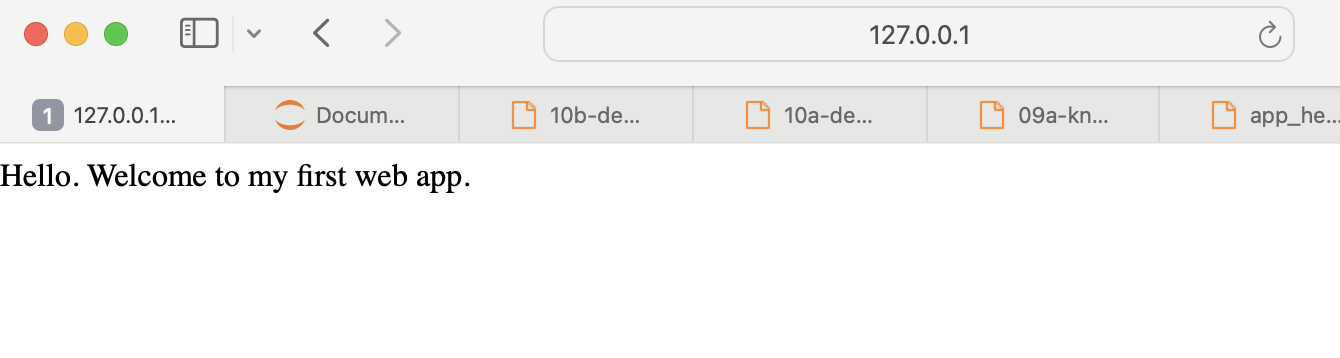

### Запуск приложения, которое определяет вид пингвинов

Код приложения для определения вида пингвинов находится в файле ```app.py```:
```python
from flask import Flask, request, Response
import json

# импорт кода классификатора
from penguins import penguins_classifier

app = Flask(__name__)

@app.route("/")
def hello():
    return "Hello. Welcome to my first web app."

# вызов классификатора
@app.route("/penguins", methods=["POST"])
def penguins():
    
    request_data = request.json # распаковываем данные из формата JSON
    response = penguins_classifier(request_data) # запускаем классификатор
    return json.dumps(response)

if __name__ == "__main__":
    app.run()
```

Чтобы запустить его, нужно набрать в командной строке следующую команду (если там еще работает предыдущее приложение, его надо остановить:
```shell
flask --app app.py run
```


К нему из браузера можно будет обратиться только через JavaScript, но мы можем обратиться к нему прямо из текущей тетради. Для этого нам понадобится модуль ```requests```.

In [ ]:
!pip install requests

In [ ]:
import requests
import json

url = 'http://127.0.0.1:5000/penguins'

data = test_penguins
data_to_send = json.dumps(data) # отправляем данные в формате JSON
response = requests.post(url, 
                         data_to_send, 
                         headers={'Content-Type': 'application/json'})
print(response.text)